### Compute High Cloud Top Temperature Distributions
We'd love to compare high cloud top temperature distributions across models! This code should execute with Healpix model data. Some notes:
- Cell 4 should be edited to load your model catalogue
- The cloud fraction condition (cloud area fraction > 99) might need model-specific editing (some models define cloud fraction out of 100, some out of 1)

Once you've executed the notebook, please share at least a) your histogram dictionary and b) your composite netcdf by saving in this folder (hk25-HighCloudT) and creating a pull request. Please label your model in the filename. Thank you!

In [1]:
MODEL_NAME = 'xshield24' ## enter your model name for labelling

In [2]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr       

from dask.diagnostics import ProgressBar
import seaborn as sns

from scipy import stats


In [3]:
# I like serif fonts
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams["mathtext.fontset"] = 'stix'
plt.rcParams['text.usetex'] = False
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.rcParams['figure.dpi'] = 70 # change for figure quality

### Edit this cell to load your catalogue!

In [4]:
### Load your catalogue here

catfn='/home/tmerlis/hackathon/xsh24_scream_main.yaml'
combo_cat = intake.open_catalog(catfn)
# 'coarse' is an online coarse-graining of 8 neighboring grid cells ~25km
# xsh24 = X-SHiELD 2024 model version, unpublished
# xsh21 = X-SHiELD 2021 model version, many articles including Cheng et al. 2022 GRL
print (list(combo_cat)) 

### we should use the highest resolution we can, to resolve the clouds
# select zoom level and the part of the combined catalog you're interested in
# coarse stores are available at zoom 7 ~50km and lower
zoom_select = 7
ds = combo_cat.xsh24_coarse(zoom=zoom_select).to_dask()
# attach coordinates; otherwise can't use lat and lon and selecting regions or taking a zonal mean won't work
ds = ds.pipe(egh.attach_coords)



['xsh24_coarse', 'xsh24_native', 'xsh21_coarse', 'scream2D_hrly', 'scream_ne120', 'scream_lnd']


/home/pc6491/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


### Edit this cell if your definition of cloud fraction differs from ours

In [5]:
## cloud fraction > 99% and cloud ice content > 10^{-1}
# the histograms may be somewhat sensitive to your cloud fraction threshold
# your model may define cloud fraction from 0 to 1 or from 0 to 100

mask = ((ds.clt > 99) & (ds.clivi > 10**(-1))).compute()

In [6]:
# select cells
high_cloud_cells = ds.where(mask, drop = True)

In [7]:
# select OLR
cloudy_OLR = high_cloud_cells.rlut

In [8]:
from scipy.constants import sigma as SB_sigma

def BT_from_OLR(OLR):
    # compute brightness temperature
    # check if your OLR is hemispherically integrated: should you divide by pi?
    T = (OLR/(SB_sigma))**(1/4)
    return T

In [9]:
cloudy_BT = BT_from_OLR(cloudy_OLR)

In [10]:
# bin brightness temperature by latitude
lat_bins = np.arange(-90, 91, 10)
lat_binned = cloudy_BT.groupby_bins(cloudy_BT.lat, bins=lat_bins)


In [11]:
## compute compressed data and save in dictionary for easy/fast plotting
def prep_lat_data_for_plots(binned, tmin = 200, tmax = 270):
    hist_data = {}
    for bin_name, bin_data in binned:
        with ProgressBar():
            bin_values = bin_data.values.flatten()
            bin_values = bin_values[~np.isnan(bin_values)]
            freq, bin_edges = np.histogram(bin_values, bins=np.arange(tmin, tmax))
            hist_data[bin_name] = (freq, bin_edges)
    return hist_data

In [12]:
hist_data = prep_lat_data_for_plots(lat_binned)

[########################################] | 100% Completed | 2.44 sms
[########################################] | 100% Completed | 2.42 sms
[########################################] | 100% Completed | 2.15 sms
[########################################] | 100% Completed | 2.38 sms
[########################################] | 100% Completed | 2.17 sms
[########################################] | 100% Completed | 2.69 sms
[########################################] | 100% Completed | 2.37 sms
[########################################] | 100% Completed | 2.40 sms
[########################################] | 100% Completed | 2.56 sms
[########################################] | 100% Completed | 2.63 sms
[########################################] | 100% Completed | 2.38 sms
[########################################] | 100% Completed | 2.62 sms
[########################################] | 100% Completed | 2.43 sms
[########################################] | 100% Completed | 2.44 sms
[#####

In [13]:
## please send us your histograms!
np.save('hist_data_' + MODEL_NAME + '.npy', hist_data) 

In [14]:
# unpack brightness temperature data for fast plotting 
cloudy_BT = cloudy_BT.compute()

In [15]:
## compute composite data for map
cloudy_composite = cloudy_BT.mean(axis = 0, skipna = True)

In [16]:
## please also provide us with your temporal means!
cloudy_composite.to_netcdf(MODEL_NAME + '_composite.nc')

/tmp/ipykernel_537830/1268280398.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


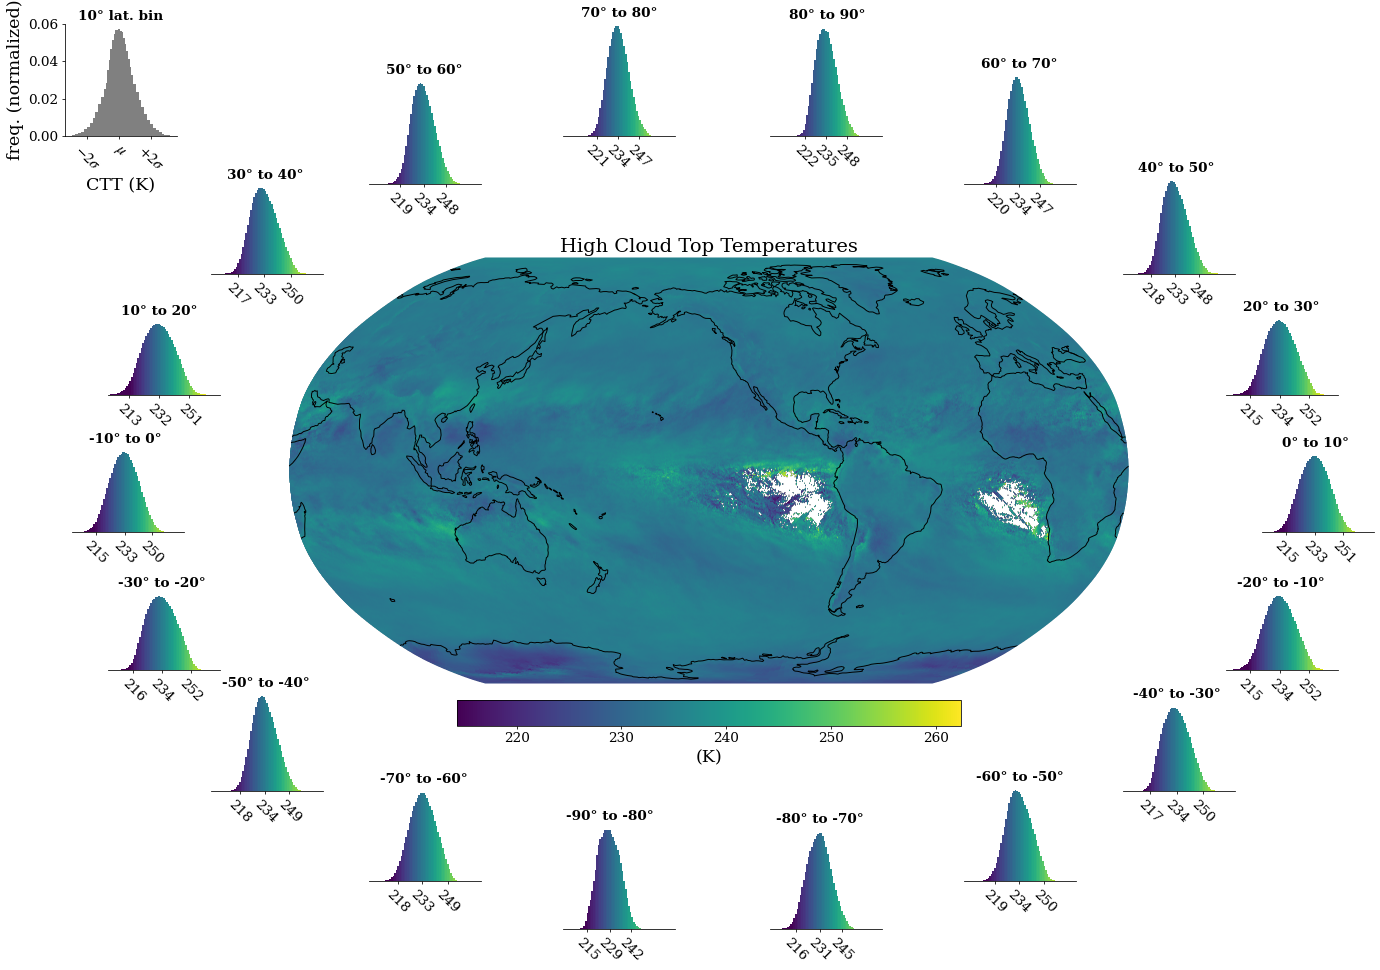

In [17]:
# create figure: map in the middle, latitudinal bins around
fig = plt.figure(figsize=(20, 20))

# Central map plot
ax_map = fig.add_axes([0.19, 0.25, 0.6, 0.6], projection = ccrs.Robinson(central_longitude = -135))
ax_map.set_global()
ax_map.coastlines()
hpshow = egh.healpix_show(cloudy_composite, ax=ax_map)
cbar = plt.colorbar(hpshow, ax=ax_map, location = 'bottom', pad=0.02, shrink=0.6)
ax_map.set_title("High Cloud Top Temperatures", fontsize = 20)
cbar.set_label(label='(K)')

# Remove map axes
ax_map.axis('off')

# Get the colormap from hpshow (so we can color-code the bars later)
cmap = hpshow.get_cmap()
norm = hpshow.norm

# Calculate positions for surrounding histograms using an elliptical arrangement
# adjust these to prevent axis overlap
radius_x = 1.7  # Reduced horizontal spread
radius_y = 1.15  # Reduced vertical spread
angles = np.linspace(-np.pi, np.pi, 18, endpoint=False)
# we want the polar lats at the poles, equator at equator, etc.
reindex = np.array([4, 5, 3, 6, 2, 7, 1, 8, 0, 9, 17, 10, 16, 11, 15, 12, 14, 13])

for i, (bin_name, bin_data) in enumerate(hist_data.items()):
    freq, bin_edges = bin_data
    instances = np.sum(freq)

    bin_start, bin_end = bin_name.left, bin_name.right
    
    # Adjust angle to match latitude (reindex manually)
    lat_center = (bin_start + bin_end) / 2
    angle_adj = angles[reindex[i]]
    
    # Calculate position with elliptical adjustment
    x = radius_x * np.cos(angle_adj)
    y = radius_y * np.sin(angle_adj)
    
    # Convert to grid coordinates (0-4 range)
    x = 2 + x
    y = 2 + y
    
    # Create smaller subplot with adjusted position and size
    ax = plt.axes([x/4 - 0.04, y/4 - 0.04, 0.08, 0.08])

    # Create histogram
    n, bins, patches = ax.hist(bin_edges[:-1], bins=bin_edges, weights=freq/instances, edgecolor='None', align='left')

    # Color the histogram bars according to the central map's colormap
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    for patch, center in zip(patches, bin_centers):
        color = cmap(norm(center))
        patch.set_facecolor(color)
        
    # label the lat bin
    ax.set_xlim([200, 270])
    ax.set_ylim([0, 0.06])
    temp_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    hist_mean = np.sum(temp_centers * freq) / instances
    sigma = np.sqrt(np.sum(freq * (bin_centers - hist_mean)**2) / instances)
    two_sigma = 2*sigma
    ax.set_xticks(np.array([int(hist_mean - two_sigma), int(hist_mean), int(hist_mean + two_sigma)]))
    ax.patch.set_facecolor('none') #make transparent to help with overlapping subplots
    ax.tick_params("x", rotation=-45)
    ax.text(hist_mean, np.max(freq/instances) + 0.005, f'{bin_start:.0f}° to {bin_end:.0f}°', fontsize=14, ha='center', fontweight = 'bold')

    
    # Remove all axes, ticks and labels
    sns.despine(ax = ax)
    sns.despine(ax = ax, left = 'True')
    ax.set_yticks([], [])


## show labels
ax_legend = fig.add_axes([0.03, 0.743, 0.08, 0.08])
n, bins, patches = ax_legend.hist(bin_edges[:-1], bins=bin_edges, weights=freq/instances, edgecolor='None', align='left', color = 'grey')
N = instances
x = stats.norm.rvs(235, 10, size=N)
ax_legend.hist(x, bins=50, facecolor='grey', density = True)

ax_legend.set_xlim([200, 270])
ax_legend.set_xlabel("CTT (K)")
ax_legend.set_ylim([0, 0.06])
ax_legend.set_ylabel("freq. (normalized)")
temp_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
hist_mean = np.mean(x)
two_sigma = 20
ax_legend.set_xticks(np.array([int(hist_mean - two_sigma), int(hist_mean), int(hist_mean + two_sigma)]), labels = ['$-2\\sigma$', '$\\mu$', '$+2\\sigma$'], fontsize = 16)
ax_legend.patch.set_facecolor('none') #make transparent to help with overlapping subplots
ax_legend.tick_params("x", rotation=-45)
ax_legend.text(hist_mean, np.max(freq/instances) + 0.005, '10° lat. bin', fontsize=14, ha='center', fontweight = 'bold')

# Remove all axes, ticks and labels
sns.despine(ax = ax_legend)


plt.tight_layout()
plt.savefig('CTT_' + MODEL_NAME + '.png', dpi = 600)
plt.show()
